In [1]:
import glob
import os
from typing import Callable

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb


In [2]:
start = "2019-03-01"
end = "2023-03-01"

date_range = pd.date_range(start=start, end=end, freq="D")


In [3]:
df = pd.DataFrame()

df["Date"] = date_range
df.set_index("Date", inplace=True)


In [4]:
def get_sentiment_files(folder_path: str) -> list[str]:
    return [file for file in glob.glob(os.path.join(folder_path, "*.csv")) if "_all" not in file and "Electricity" not in file]


In [5]:
def get_sentiment_file_parts(file_path: str) -> tuple[str, str]:
    file_name = os.path.basename(file_path)
    file_name_parts = file_name.split("_")

    return file_name_parts[1], file_name_parts[2]


In [6]:
def add_sentiment_columns(big_df: pd.DataFrame, folder_path: str) -> pd.DataFrame:
    files = get_sentiment_files(folder_path)

    for file in files:
        sentiment_df = pd.read_csv(file, index_col="Date", parse_dates=True)
        sentiment_df = sentiment_df.reindex(date_range)
        sentiment_df.rolling(window=3, min_periods=1).mean()
        sentiment_df = sentiment_df.bfill()
        sentiment_df = sentiment_df.ffill()

        source, name = get_sentiment_file_parts(file)

        sentiment_df.rename(columns={"Sentiment": f"{source} {name}"}, inplace=True)
        big_df = pd.merge(big_df, sentiment_df, how="left", left_index=True, right_index=True)

    return big_df


In [7]:
def get_prices_files(folder_path: str) -> list[str]:
    return [file for file in glob.glob(os.path.join(folder_path, "*.csv")) if "Electricity" not in file]


In [8]:
def add_prices_column(big_df: pd.DataFrame, folder_path: str) -> pd.DataFrame:
    files = get_prices_files(folder_path)

    for file in files:
        prices_df = pd.read_csv(file, index_col="Date", parse_dates=True)

        prices_df.drop(["Open", "High", "Low", "Change %"], axis=1, inplace=True)
        prices_df = prices_df.reindex(date_range)
        prices_df["Price"] = prices_df["Price"].rolling(window=5, min_periods=1).mean()
        prices_df = prices_df.shift()
        prices_df.iloc[0, 0] = prices_df.iloc[1, 0]
        prices_df = prices_df.bfill()

        name = os.path.basename(file).replace(".csv", "")

        prices_df.rename(columns={"Price": f"{name} Price"}, inplace=True)
        big_df = pd.merge(big_df, prices_df, how="left", left_index=True, right_index=True)

    return big_df


In [9]:
data_sources = ["GDELT", "Google News", "Twitter", "Prices"]
prices = ["BSE Price", "Crude Oil Price", "Dow Jones Price", "FTSE Price", "Gold Price", "Hang Seng Price", "Natural Gas Price", "S&P500 Price"]

# parameter: a function that returns the path to the folders that contain the average daily sentiments. The folders are structured as follows: Data\{data_source}\Sentiment
data_path: Callable[[str], str] = lambda x: f"D:\data-science-project\Data\{x}\Sentiment"


In [10]:
for data_source in data_sources:
    df = add_sentiment_columns(df, data_path(data_source))

df = add_prices_column(df, "D:\data-science-project\Data\Prices\Ready")


In [11]:
df.isna().sum()


GDELT BSE                  0
GDELT Crude Oil            0
GDELT Dow Jones            0
GDELT FTSE                 0
GDELT Gold                 0
GDELT Hang Seng            0
GDELT Natural Gas          0
GDELT S&P500               0
Google News BSE            0
Google News Crude Oil      0
Google News Dow Jones      0
Google News FTSE           0
Google News Gold           0
Google News Hang Seng      0
Google News Natural Gas    0
Google News S&P500         0
Twitter BSE                0
Twitter Crude Oil          0
Twitter Dow Jones          0
Twitter FTSE               0
Twitter Gold               0
Twitter Hang Seng          0
Twitter Natural Gas        0
Twitter S&P500             0
BSE Price                  0
Crude Oil Price            0
Dow Jones Price            0
FTSE Price                 0
Gold Price                 0
Hang Seng Price            0
Natural Gas Price          0
S&P500 Price               0
dtype: int64

In [24]:
df[[column for column in df.columns if "Dow Jones" in column or "BSE" in column]].head(10)[["Dow Jones Price", "GDELT Dow Jones", "Google News Dow Jones", "Twitter Dow Jones", "BSE Price"]]


Dow Jones Price  GDELT Dow Jones  Google News Dow Jones  \
Date                                                                  
2019-03-01       26026.3200         0.605613               0.289022   
2019-03-02       26026.3200         0.580290               0.250733   
2019-03-03       26026.3200         0.350027               0.476049   
2019-03-04       26026.3200         0.485935               0.266913   
2019-03-05       25922.9850         0.416681               0.337445   
2019-03-06       25884.2000         0.362130               0.383295   
2019-03-07       25766.5800         0.298587               0.321388   
2019-03-08       25693.2425         0.227552               0.389360   
2019-03-09       25644.6420         0.301930               0.443945   
2019-03-10       25600.8900         0.408526               0.407779   

            Twitter Dow Jones     BSE Price  
Date                                         
2019-03-01           0.231264  36063.810000  
2019-03-02           0.231264  36063.810000  
2019-03-03           0.312400  36063.810000  
2019-03-04           0.244231  36063.810000  
2019-03-05           0.244231  36063.810000  
2019-03-06           0.244231  36253.175000  
2019-03-07           0.244231  36539.320000  
2019-03-08           0.657948  36601.353333  
2019-03-09           0.657948  36618.872500  
2019-03-10           0.657948  36618.872500

In [13]:
df[df.isnull().any(axis=1)]


Empty DataFrame
Columns: [GDELT BSE, GDELT Crude Oil, GDELT Dow Jones, GDELT FTSE, GDELT Gold, GDELT Hang Seng, GDELT Natural Gas, GDELT S&P500, Google News BSE, Google News Crude Oil, Google News Dow Jones, Google News FTSE, Google News Gold, Google News Hang Seng, Google News Natural Gas, Google News S&P500, Twitter BSE, Twitter Crude Oil, Twitter Dow Jones, Twitter FTSE, Twitter Gold, Twitter Hang Seng, Twitter Natural Gas, Twitter S&P500, BSE Price, Crude Oil Price, Dow Jones Price, FTSE Price, Gold Price, Hang Seng Price, Natural Gas Price, S&P500 Price]
Index: []

[0 rows x 32 columns]

In [14]:
os.makedirs("models", exist_ok=True)
os.makedirs("importances", exist_ok=True)


Training BSE Price model
X train: (1169, 31), X test: (293, 31), Y train: (1169,), Y test: (293,)
R2 score: 0.9967738200002751
Mean squared error: 296633.94759573933
Mean absolute error: 393.07307561860057


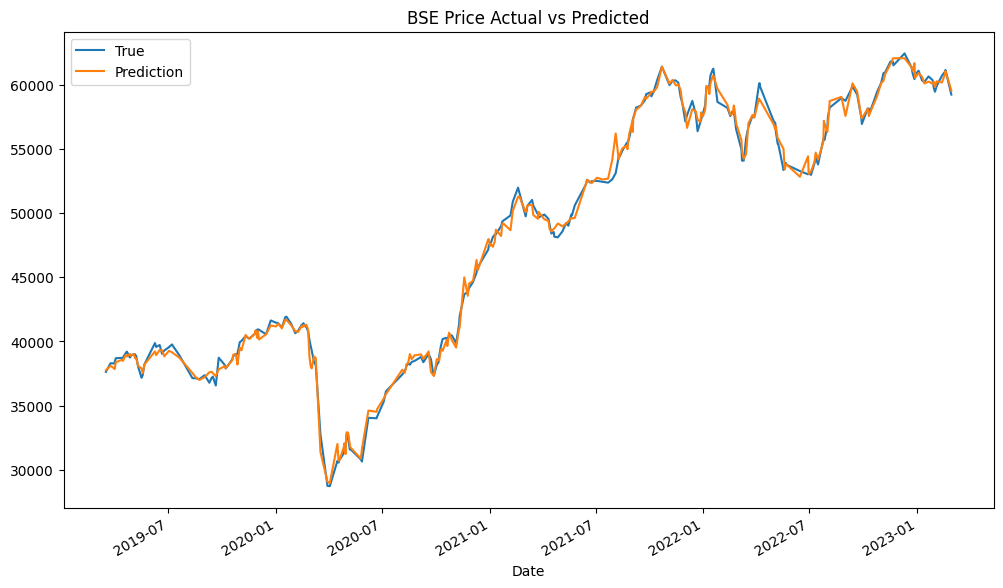

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


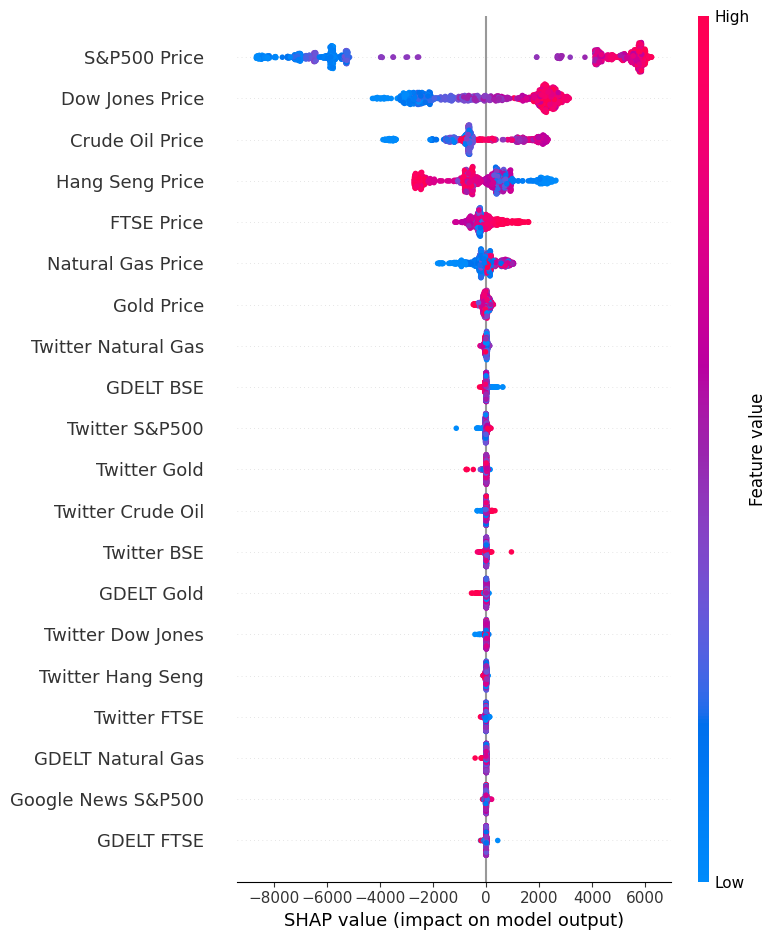

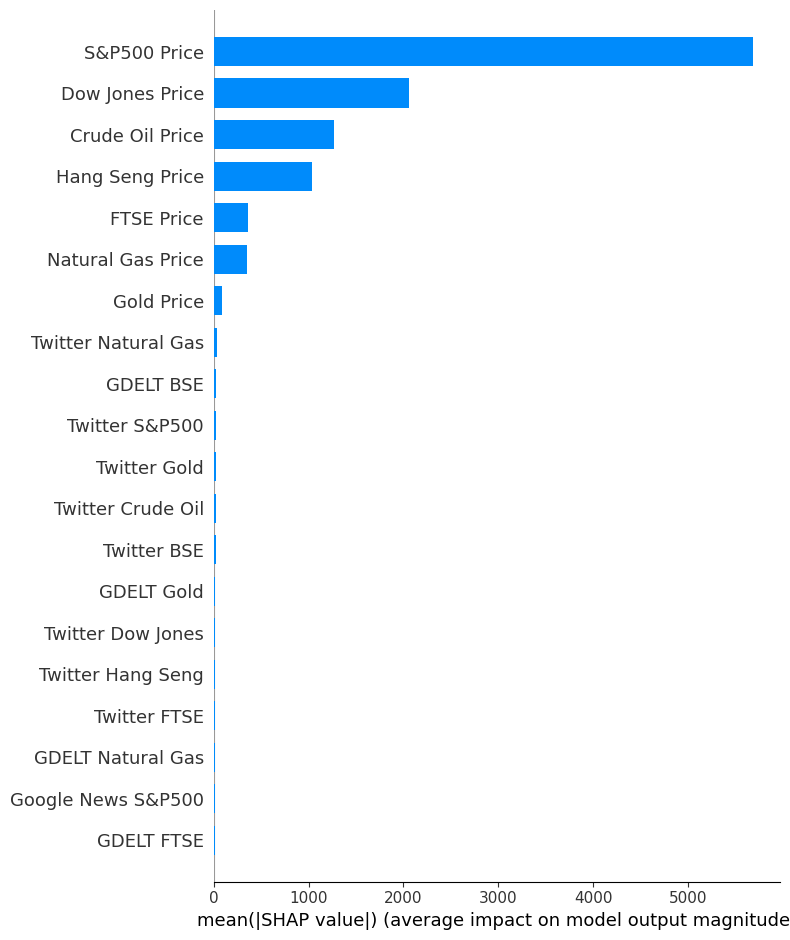

                          A          B   Importance
30             S&P500 Price  BSE Price  5683.635742
25          Dow Jones Price  BSE Price  2060.254639
24          Crude Oil Price  BSE Price  1270.301392
28          Hang Seng Price  BSE Price  1030.703613
26               FTSE Price  BSE Price   362.009766
29        Natural Gas Price  BSE Price   349.433533
27               Gold Price  BSE Price    83.306892
22      Twitter Natural Gas  BSE Price    32.068684
0                 GDELT BSE  BSE Price    28.200291
23           Twitter S&P500  BSE Price    27.984734
20             Twitter Gold  BSE Price    22.472401
17        Twitter Crude Oil  BSE Price    21.950335
16              Twitter BSE  BSE Price    20.930920
4                GDELT Gold  BSE Price    17.034851
18        Twitter Dow Jones  BSE Price    16.922153
21        Twitter Hang Seng  BSE Price    15.229757
19             Twitter FTSE  BSE Price    14.059636
6         GDELT Natural Gas  BSE Price    13.506889
15       Goo

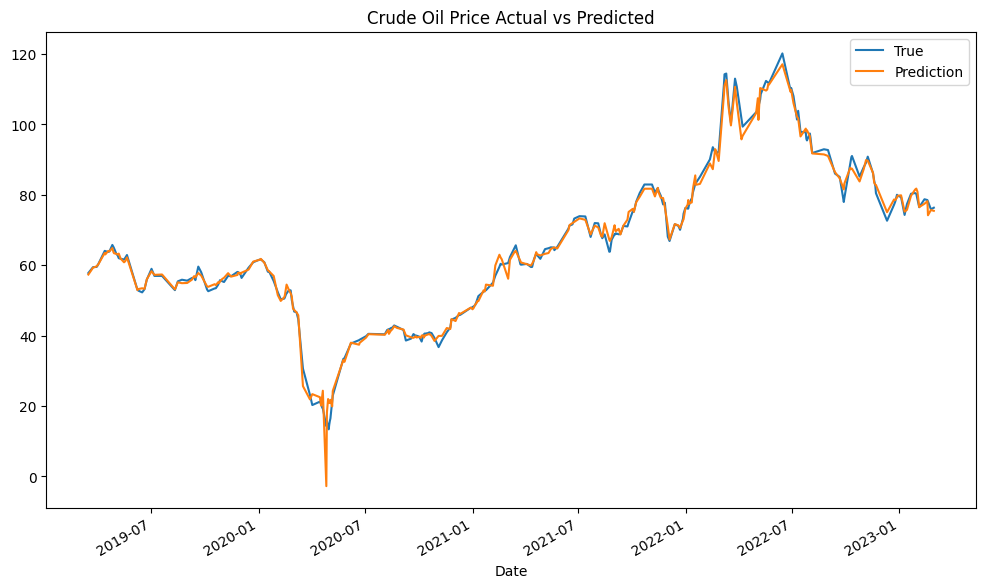

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


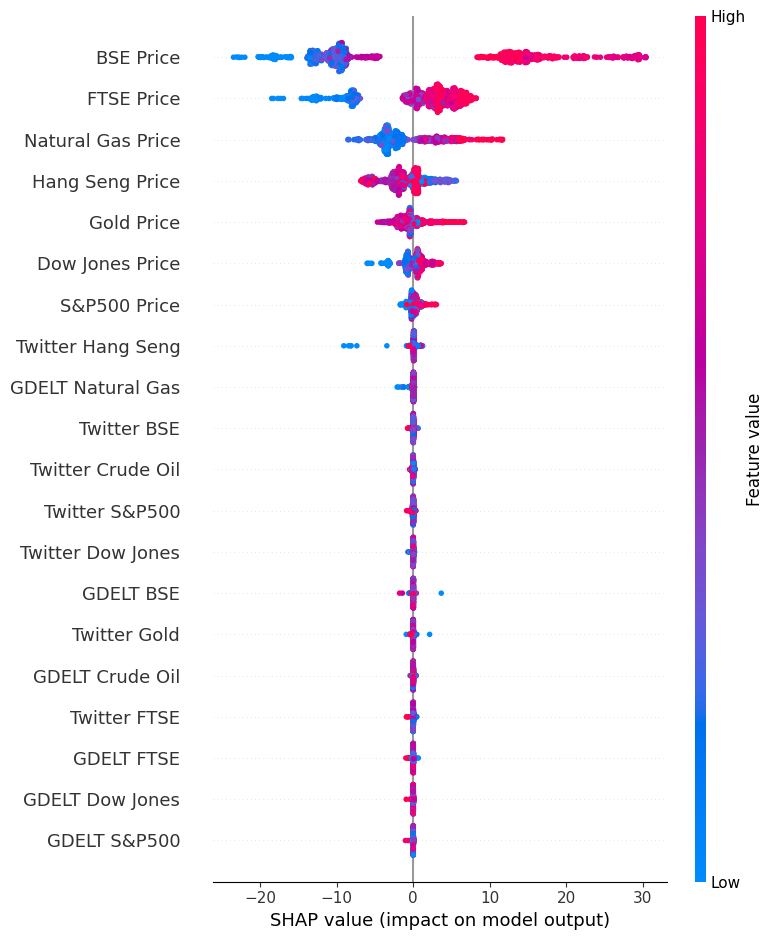

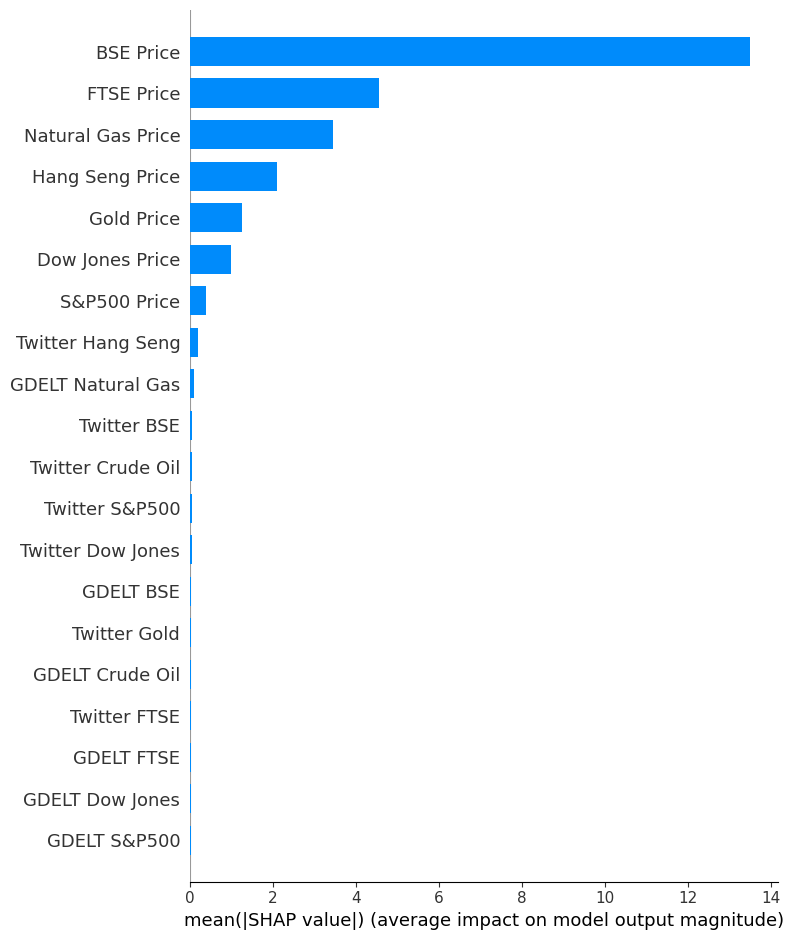

                          A                B  Importance
24                BSE Price  Crude Oil Price   13.495399
26               FTSE Price  Crude Oil Price    4.544727
29        Natural Gas Price  Crude Oil Price    3.441374
28          Hang Seng Price  Crude Oil Price    2.094944
27               Gold Price  Crude Oil Price    1.250450
25          Dow Jones Price  Crude Oil Price    0.978330
30             S&P500 Price  Crude Oil Price    0.386239
21        Twitter Hang Seng  Crude Oil Price    0.182525
6         GDELT Natural Gas  Crude Oil Price    0.088198
16              Twitter BSE  Crude Oil Price    0.056845
17        Twitter Crude Oil  Crude Oil Price    0.052379
23           Twitter S&P500  Crude Oil Price    0.052106
18        Twitter Dow Jones  Crude Oil Price    0.039463
0                 GDELT BSE  Crude Oil Price    0.036219
20             Twitter Gold  Crude Oil Price    0.035827
1           GDELT Crude Oil  Crude Oil Price    0.034341
19             Twitter FTSE  Cr

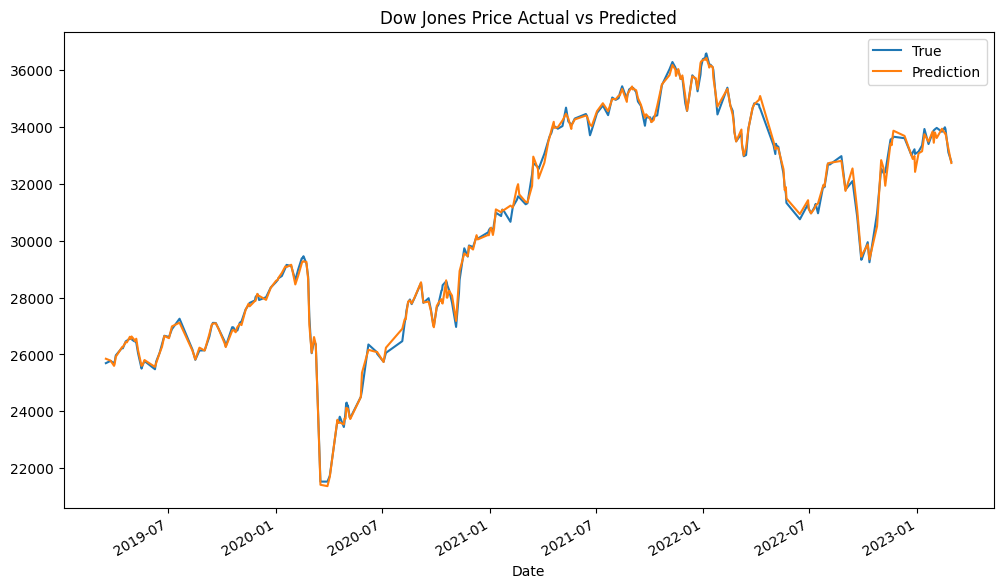

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


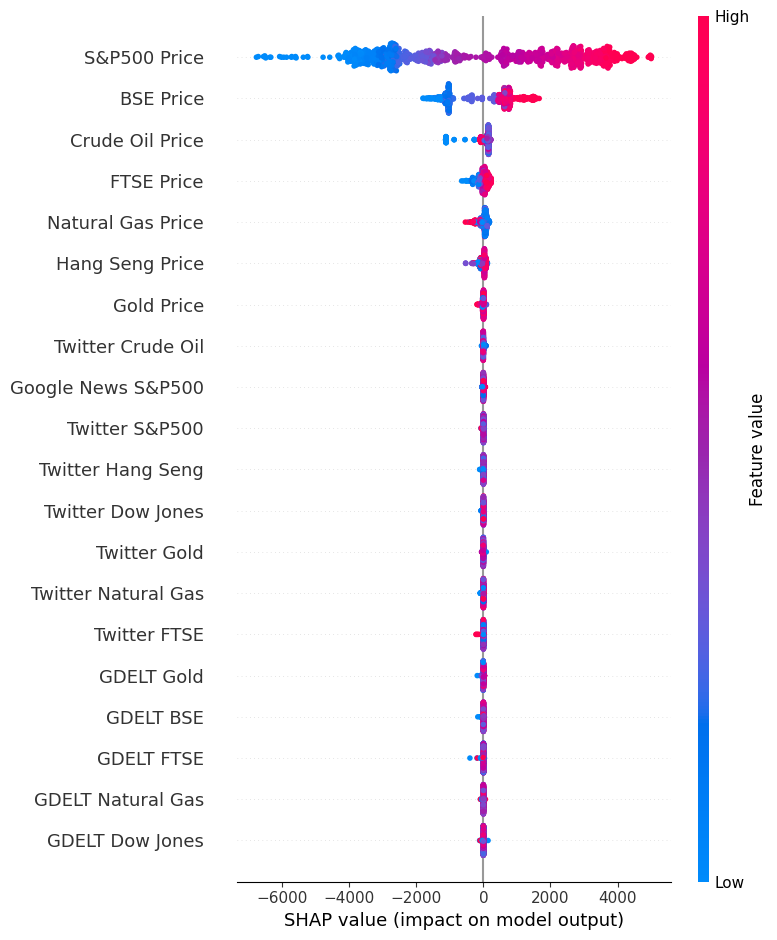

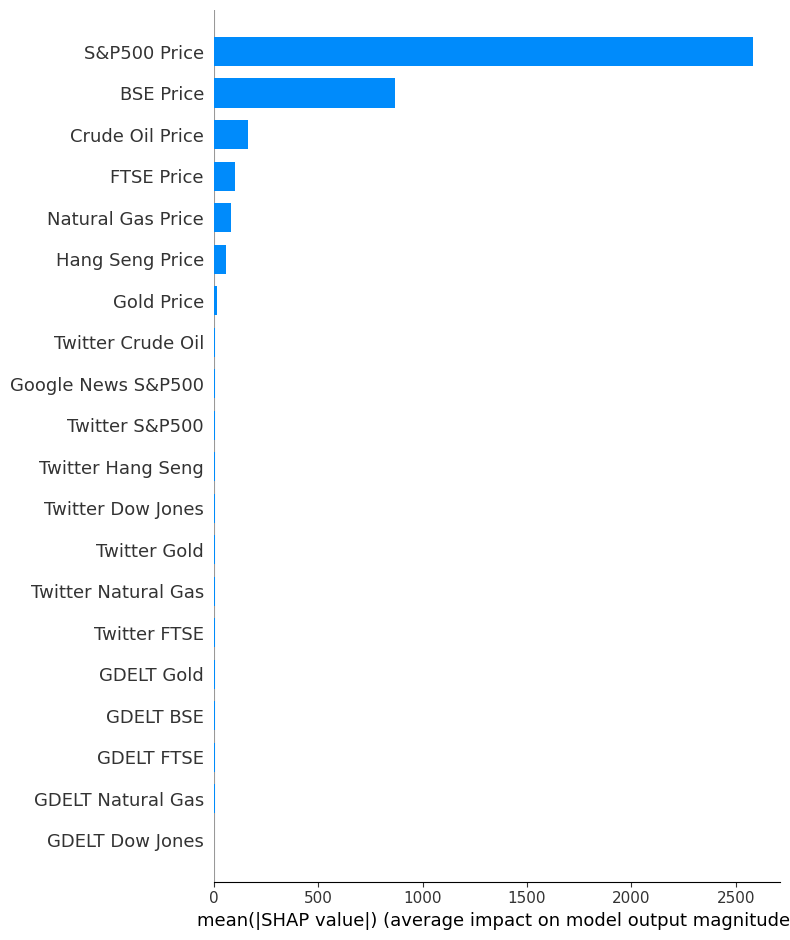

                          A                B   Importance
30             S&P500 Price  Dow Jones Price  2582.385742
24                BSE Price  Dow Jones Price   867.470276
25          Crude Oil Price  Dow Jones Price   162.048767
26               FTSE Price  Dow Jones Price   102.126862
29        Natural Gas Price  Dow Jones Price    83.073051
28          Hang Seng Price  Dow Jones Price    57.964287
27               Gold Price  Dow Jones Price    15.884817
17        Twitter Crude Oil  Dow Jones Price     7.077483
15       Google News S&P500  Dow Jones Price     6.467274
23           Twitter S&P500  Dow Jones Price     6.388835
21        Twitter Hang Seng  Dow Jones Price     6.042185
18        Twitter Dow Jones  Dow Jones Price     5.951565
20             Twitter Gold  Dow Jones Price     5.867378
22      Twitter Natural Gas  Dow Jones Price     5.667079
19             Twitter FTSE  Dow Jones Price     5.489580
4                GDELT Gold  Dow Jones Price     5.447478
0             

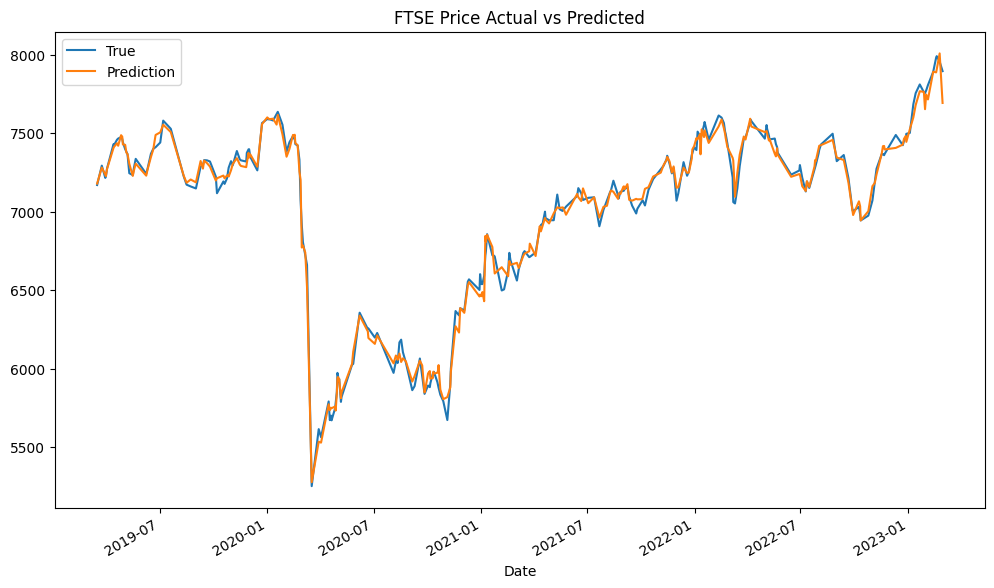

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


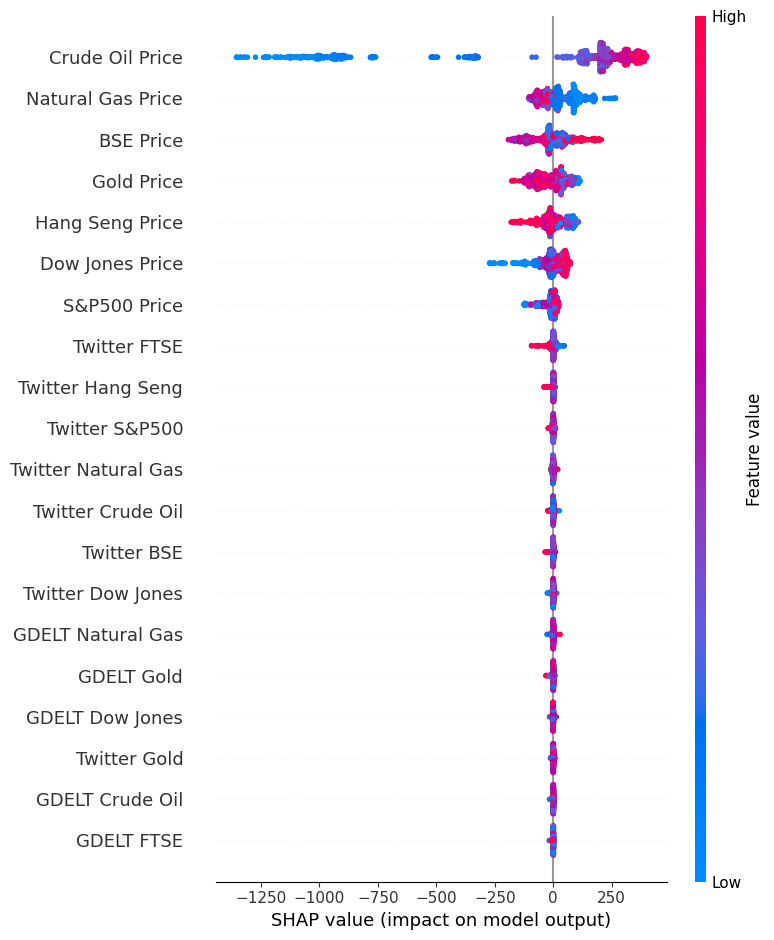

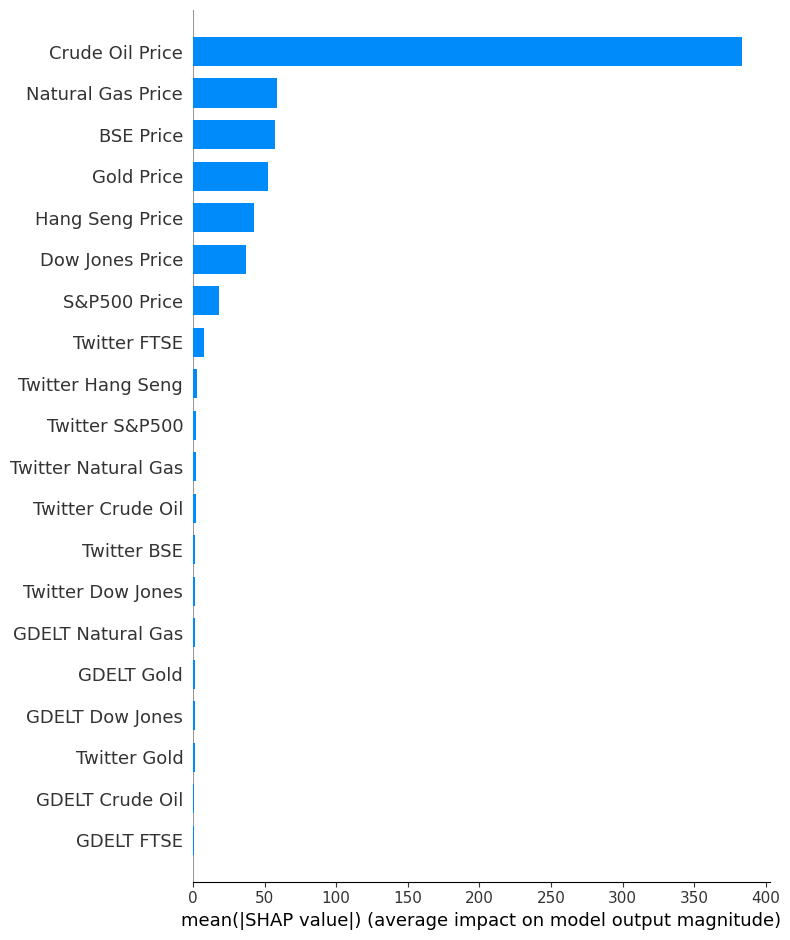

                          A           B  Importance
25          Crude Oil Price  FTSE Price  383.624390
29        Natural Gas Price  FTSE Price   58.618156
24                BSE Price  FTSE Price   57.447853
27               Gold Price  FTSE Price   52.063190
28          Hang Seng Price  FTSE Price   42.356567
26          Dow Jones Price  FTSE Price   37.059254
30             S&P500 Price  FTSE Price   18.504284
19             Twitter FTSE  FTSE Price    7.602085
21        Twitter Hang Seng  FTSE Price    3.007764
23           Twitter S&P500  FTSE Price    2.260072
22      Twitter Natural Gas  FTSE Price    2.103067
17        Twitter Crude Oil  FTSE Price    2.058559
16              Twitter BSE  FTSE Price    1.718107
18        Twitter Dow Jones  FTSE Price    1.632595
6         GDELT Natural Gas  FTSE Price    1.610063
4                GDELT Gold  FTSE Price    1.511985
2           GDELT Dow Jones  FTSE Price    1.346949
20             Twitter Gold  FTSE Price    1.089687
1           

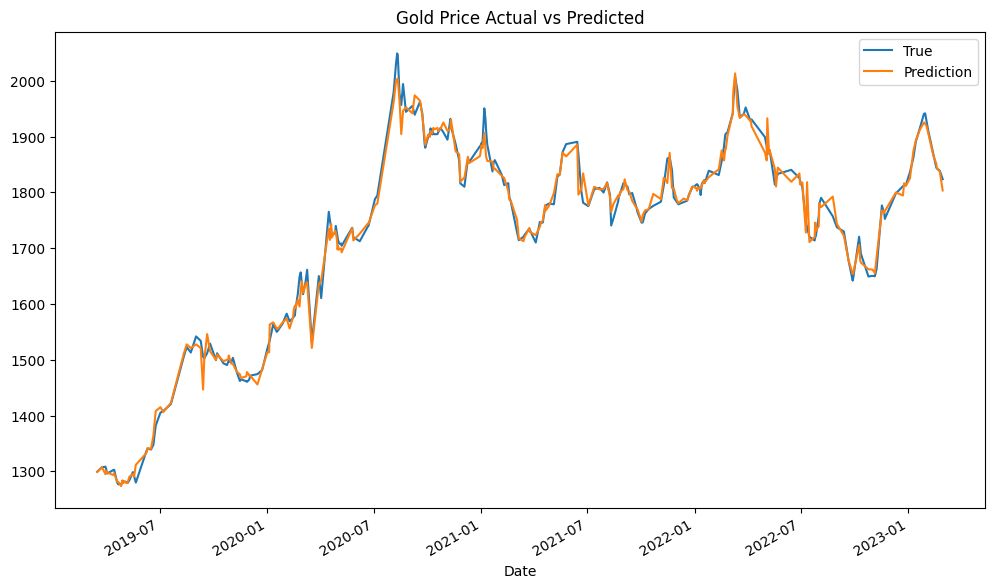

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


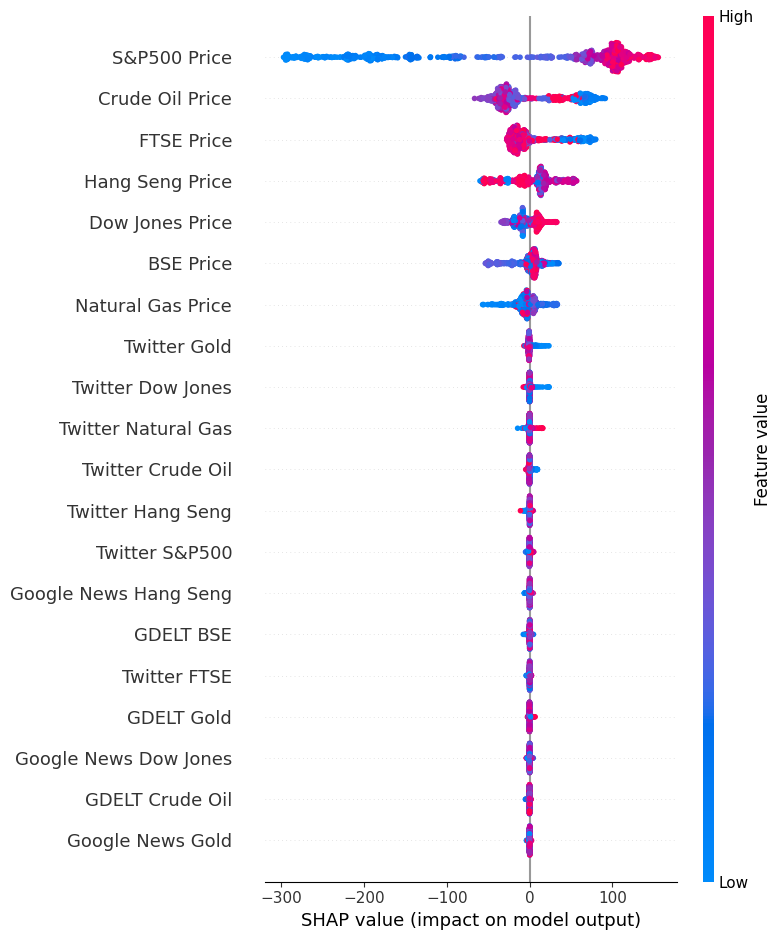

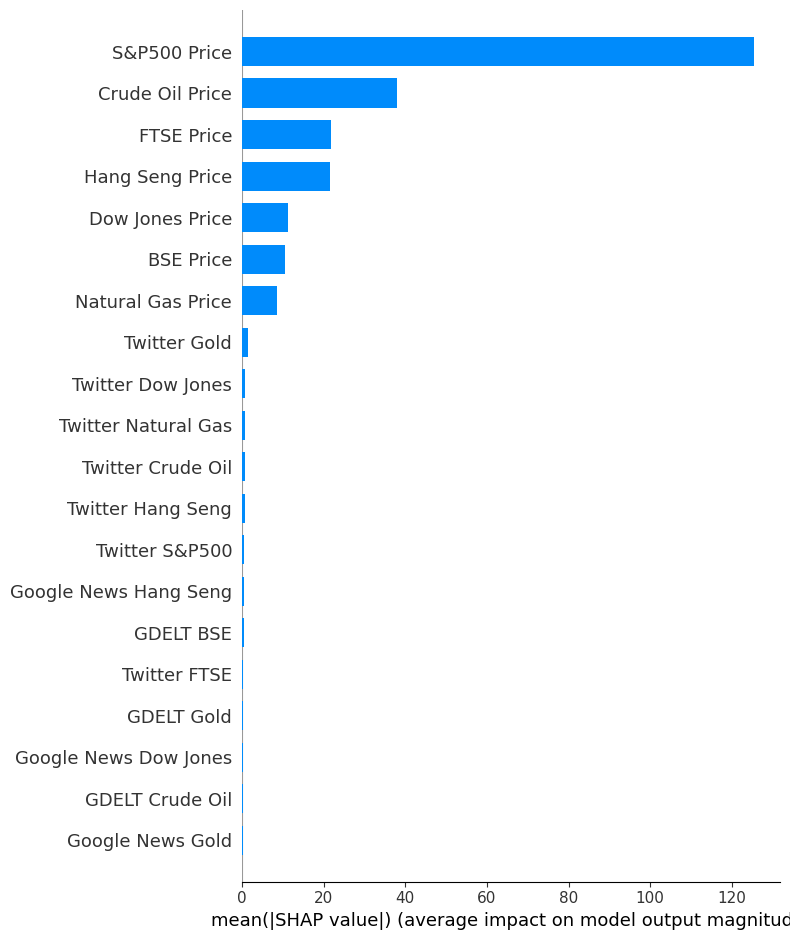

                          A           B  Importance
30             S&P500 Price  Gold Price  125.496017
25          Crude Oil Price  Gold Price   37.969021
27               FTSE Price  Gold Price   21.729734
28          Hang Seng Price  Gold Price   21.487740
26          Dow Jones Price  Gold Price   11.241800
24                BSE Price  Gold Price   10.605229
29        Natural Gas Price  Gold Price    8.511467
20             Twitter Gold  Gold Price    1.597530
18        Twitter Dow Jones  Gold Price    0.870006
22      Twitter Natural Gas  Gold Price    0.782724
17        Twitter Crude Oil  Gold Price    0.716820
21        Twitter Hang Seng  Gold Price    0.687421
23           Twitter S&P500  Gold Price    0.626437
13    Google News Hang Seng  Gold Price    0.500845
0                 GDELT BSE  Gold Price    0.445491
19             Twitter FTSE  Gold Price    0.395962
4                GDELT Gold  Gold Price    0.313798
10    Google News Dow Jones  Gold Price    0.304256
1           

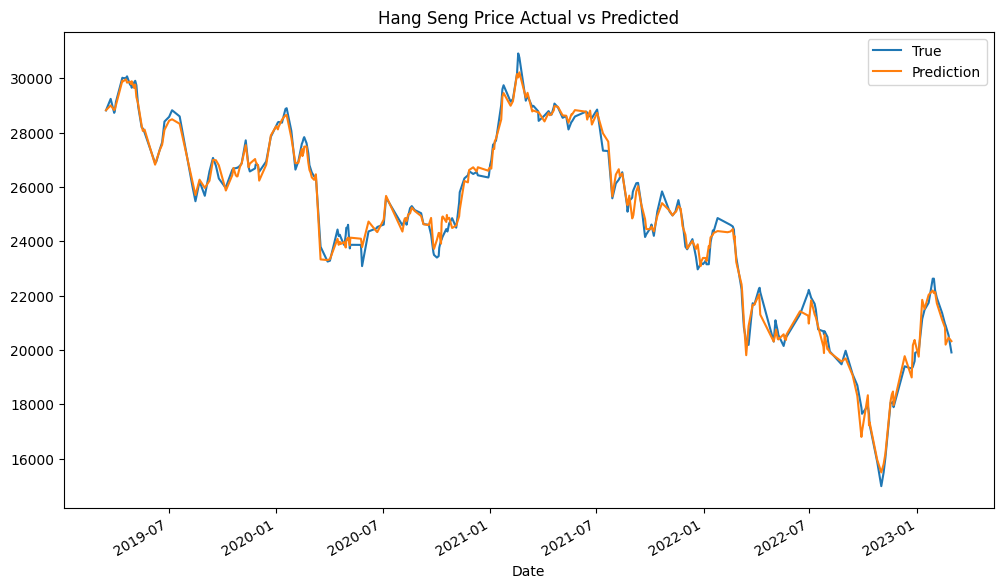

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


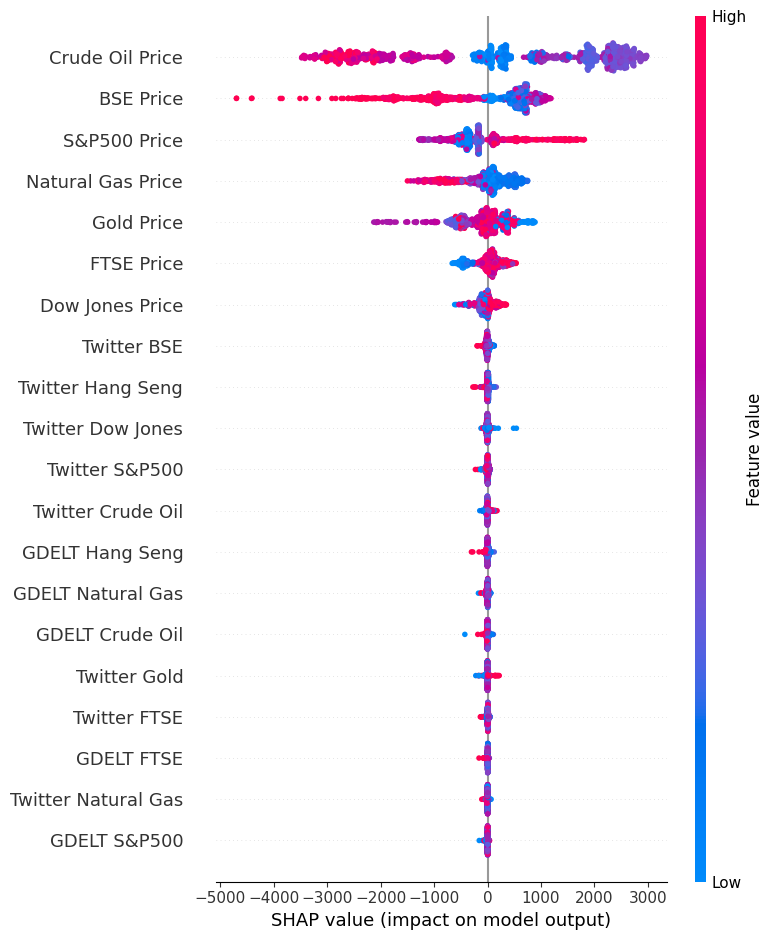

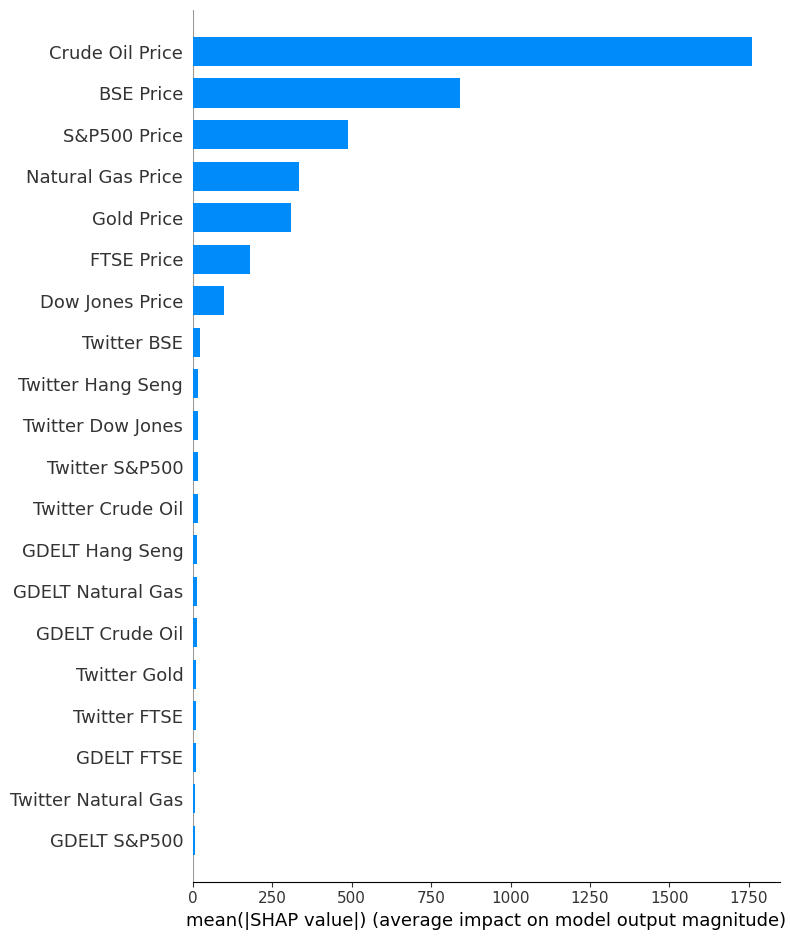

                          A                B   Importance
25          Crude Oil Price  Hang Seng Price  1760.553101
24                BSE Price  Hang Seng Price   841.174866
30             S&P500 Price  Hang Seng Price   486.739777
29        Natural Gas Price  Hang Seng Price   333.734375
28               Gold Price  Hang Seng Price   310.038635
27               FTSE Price  Hang Seng Price   178.347885
26          Dow Jones Price  Hang Seng Price    98.625969
16              Twitter BSE  Hang Seng Price    22.850443
21        Twitter Hang Seng  Hang Seng Price    17.287996
18        Twitter Dow Jones  Hang Seng Price    17.069063
23           Twitter S&P500  Hang Seng Price    14.346243
17        Twitter Crude Oil  Hang Seng Price    14.263281
5           GDELT Hang Seng  Hang Seng Price    13.651277
6         GDELT Natural Gas  Hang Seng Price    12.151294
1           GDELT Crude Oil  Hang Seng Price    11.244045
20             Twitter Gold  Hang Seng Price    11.105467
19            

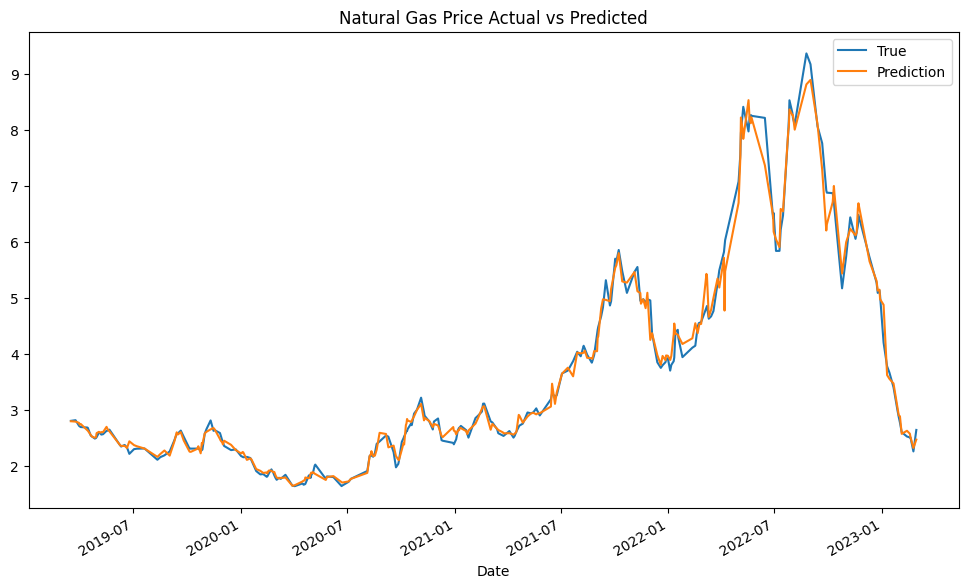

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


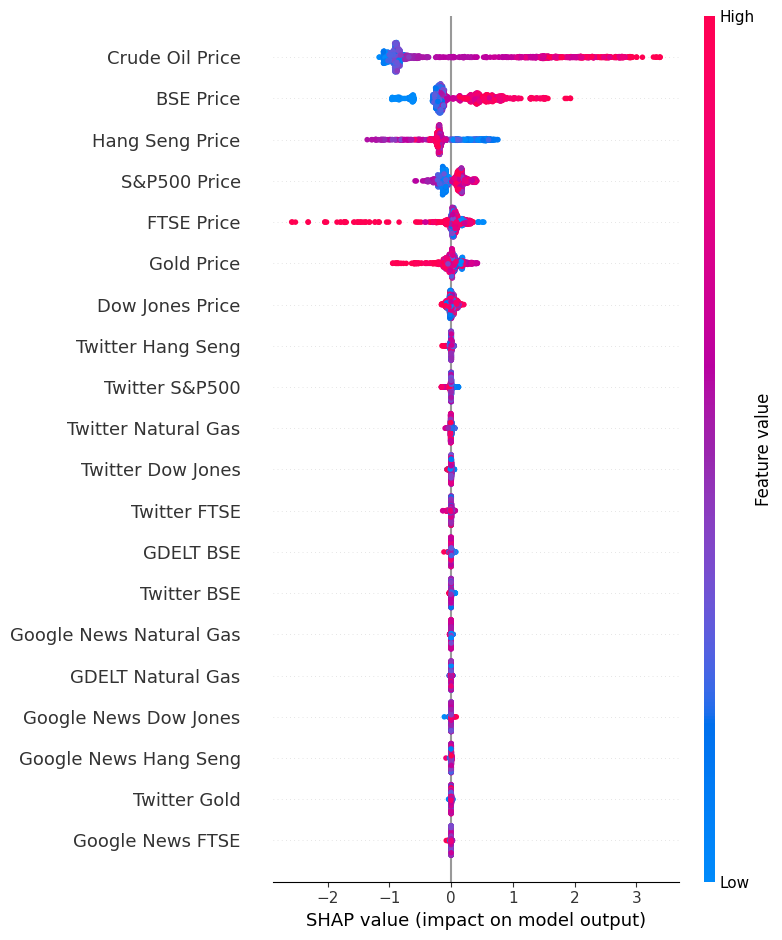

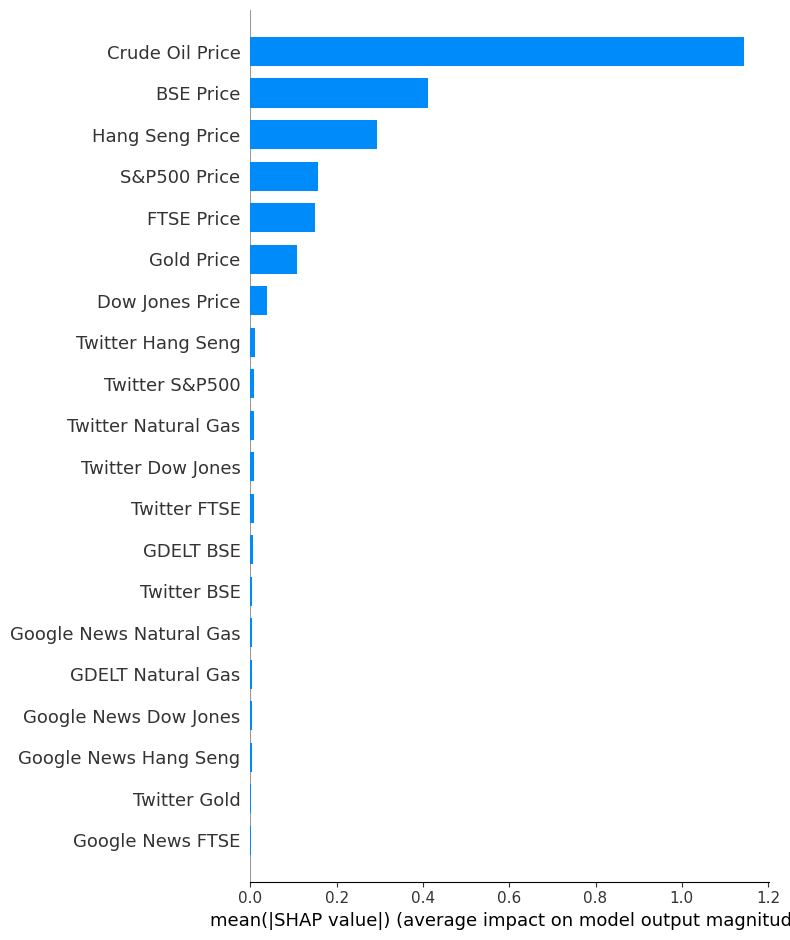

                          A                  B  Importance
25          Crude Oil Price  Natural Gas Price    1.144639
24                BSE Price  Natural Gas Price    0.410702
29          Hang Seng Price  Natural Gas Price    0.294524
30             S&P500 Price  Natural Gas Price    0.156733
27               FTSE Price  Natural Gas Price    0.149314
28               Gold Price  Natural Gas Price    0.109167
26          Dow Jones Price  Natural Gas Price    0.038362
21        Twitter Hang Seng  Natural Gas Price    0.010036
23           Twitter S&P500  Natural Gas Price    0.009490
22      Twitter Natural Gas  Natural Gas Price    0.009480
18        Twitter Dow Jones  Natural Gas Price    0.007487
19             Twitter FTSE  Natural Gas Price    0.007320
0                 GDELT BSE  Natural Gas Price    0.005340
16              Twitter BSE  Natural Gas Price    0.004458
14  Google News Natural Gas  Natural Gas Price    0.003120
6         GDELT Natural Gas  Natural Gas Price    0.0029

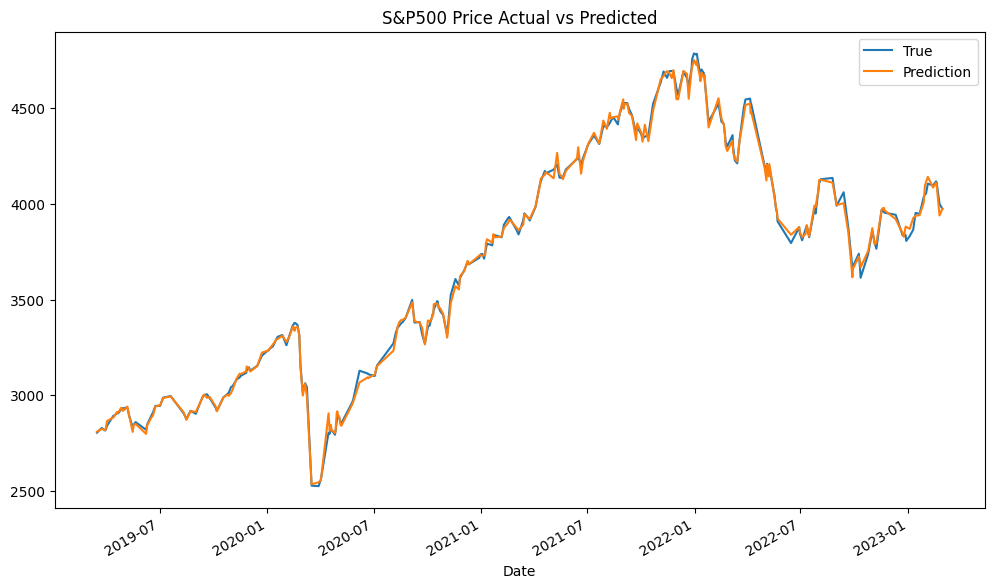

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


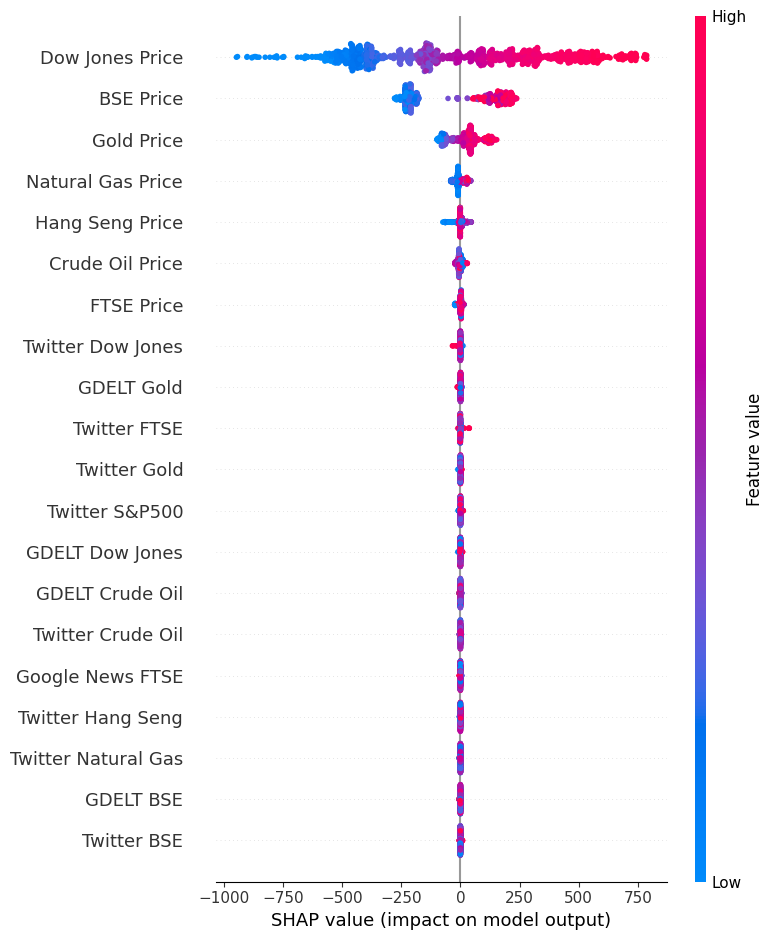

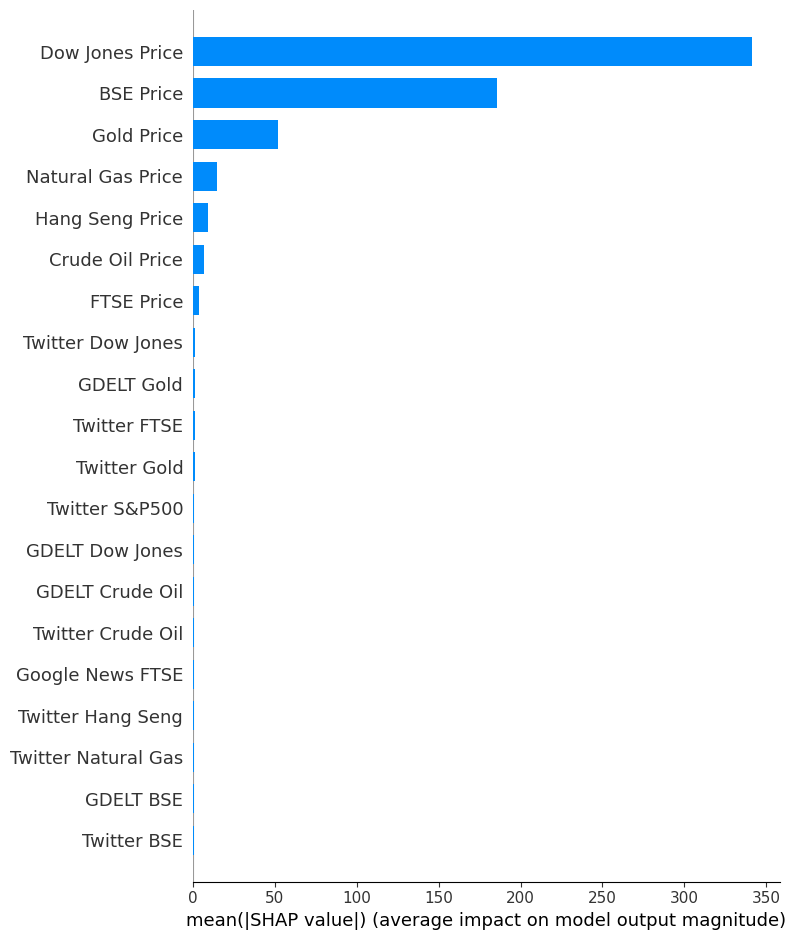

                          A             B  Importance
26          Dow Jones Price  S&P500 Price  341.073578
24                BSE Price  S&P500 Price  185.361404
28               Gold Price  S&P500 Price   51.650341
30        Natural Gas Price  S&P500 Price   14.581278
29          Hang Seng Price  S&P500 Price    9.423688
25          Crude Oil Price  S&P500 Price    6.646889
27               FTSE Price  S&P500 Price    3.624123
18        Twitter Dow Jones  S&P500 Price    1.533184
4                GDELT Gold  S&P500 Price    1.253733
19             Twitter FTSE  S&P500 Price    1.184763
20             Twitter Gold  S&P500 Price    0.990009
23           Twitter S&P500  S&P500 Price    0.763918
2           GDELT Dow Jones  S&P500 Price    0.736898
1           GDELT Crude Oil  S&P500 Price    0.709906
17        Twitter Crude Oil  S&P500 Price    0.616811
11         Google News FTSE  S&P500 Price    0.525634
21        Twitter Hang Seng  S&P500 Price    0.525143
22      Twitter Natural Gas 

In [15]:
for price in prices:
    x = df.drop(price, axis=1)
    y = df[price]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    print(f"Training {price} model")
    print(f"X train: {x_train.shape}, X test: {x_test.shape}, Y train: {y_train.shape}, Y test: {y_test.shape}")

    model = xgb.XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.05, gamma=0.02, random_state=42, objective="reg:squarederror")
    model.fit(x_train, y_train)
    model.save_model(os.path.join("models", f"{price}.json"))

    result = model.predict(x_test)

    print(f"R2 score: {r2_score(y_test, result)}")
    print(f"Mean squared error: {mean_squared_error(y_test, result)}")
    print(f"Mean absolute error: {mean_absolute_error(y_test, result)}")

    test = pd.DataFrame({"True": y_test, "Prediction": result})
    test.plot(figsize=(12, 7), title=f"{price} Actual vs Predicted")

    plt.show()

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_train.iloc[:, :])
    shap.initjs()
    shap.summary_plot(shap_values=shap_values, features=x_train.iloc[:, :])
    shap.summary_plot(shap_values=shap_values, features=x_train.iloc[:, :], plot_type="bar")

    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({"A": x_train.columns.tolist(), "B": [price] * len(x_train.columns), "Importance": shap_sum})
    importance_df = importance_df.sort_values("Importance", ascending=False)

    importance_df.to_csv(os.path.join("importances", f"{price}.csv"), index=False)
    print(importance_df)

    print()


In [16]:
items = ["Crude Oil", "Natural Gas", "Gold", "Dow Jones", "Hang Seng", "S&P500", "FTSE", "BSE"]


def which_item_is_it(item: str) -> str:
    for i in items:
        if i in item:
            return i

    return "Unknown"


In [17]:
all_importances_df = pd.DataFrame(columns=["A", "B", "Importance"])

for file in glob.glob(os.path.join("importances", "* Price.csv")):
    importance_df = pd.read_csv(file)

    importance_df["A"] = importance_df["A"].apply(which_item_is_it)
    importance_df = importance_df.groupby("A").sum(numeric_only=True)
    importance_df = importance_df.sort_values("Importance", ascending=False)
    importance_df["B"] = which_item_is_it(file)
    importance_df.index.name = "A"

    print(importance_df)
    importance_df.to_csv(os.path.join("importances", f"{which_item_is_it(file)}.csv"),columns=["B", "Importance"], index=True)

    all_importances_df = pd.concat([all_importances_df, importance_df])

all_importances_df.drop("A", axis=1, inplace=True)
all_importances_df.index.name = "A"
all_importances_df.sort_values("Importance", ascending=False, inplace=True)
all_importances_df = all_importances_df[all_importances_df.index != all_importances_df["B"]]
all_importances_df["Importance"] = MinMaxScaler((0, 1)).fit_transform(all_importances_df["Importance"].to_numpy().reshape(-1, 1))

print(all_importances_df)
all_importances_df.to_csv(os.path.join("importances", "All.csv"), index=True)


              Importance    B
A                            
S&P500       5730.771047  BSE
Dow Jones    2095.034851  BSE
Crude Oil    1312.767867  BSE
Hang Seng    1062.468496  BSE
Natural Gas   404.412978  BSE
FTSE          392.119403  BSE
Gold          133.077573  BSE
BSE            56.456673  BSE
             Importance          B
A                                 
BSE           13.611270  Crude Oil
FTSE           4.618896  Crude Oil
Natural Gas    3.569189  Crude Oil
Hang Seng      2.308834  Crude Oil
Gold           1.323827  Crude Oil
Dow Jones      1.064477  Crude Oil
S&P500         0.475982  Crude Oil
Crude Oil      0.110450  Crude Oil
              Importance          B
A                                  
S&P500       2596.913194  Dow Jones
BSE           877.571463  Dow Jones
Crude Oil     174.980641  Dow Jones
FTSE          115.910617  Dow Jones
Natural Gas    95.673534  Dow Jones
Hang Seng      67.213269  Dow Jones
Gold           28.639305  Dow Jones
Dow Jones      11.561434  